# ML Model Selector & Auto-Baseline Notebook

comprehensive machine learning model selection and baseline evaluation for tabular data.

**what this notebook does:**
1. loads your dataset (csv/excel)
2. performs deep exploratory data analysis
3. detects data quality issues (missing values, outliers, class imbalance)
4. infers problem type (classification/regression)
5. builds optimized preprocessing pipelines
6. trains and evaluates multiple baseline models
7. provides actionable recommendations with rationale
8. exports professional reports (markdown + html)

**scope**: focused on **tabular** datasets with hooks for text/time-series extensions.

## 0) Configuration

set your dataset path and target column. the notebook will auto-detect most settings.

In [1]:
# === user configuration ===
CSV_PATH = '/home/yeblad/Desktop/2018data.xlsx'   # path to your dataset file
TARGET_COLUMN = None  # target variable name (will auto-detect if None)
PROBLEM_TYPE = None   # 'classification' or 'regression' (will auto-infer if None)
ID_COLUMNS = []       # list of id columns to exclude from modeling

# performance settings
N_SPLITS = 5
RANDOM_STATE = 42
MAX_SAMPLES_FOR_QUICK_RUN = None  # limit rows for faster iteration (None = use all)

# analysis thresholds
HIGH_CARD_THRESHOLD = 50  # categorical cardinality threshold
IMBALANCE_THRESHOLD = 0.1  # minority class threshold
CORRELATION_THRESHOLD = 0.7  # high correlation threshold

## 1) Imports and Setup

In [2]:
import os, sys, math, warnings, datetime
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List

from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, cross_val_score, 
    learning_curve, validation_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report, 
    confusion_matrix, precision_recall_curve, roc_curve,
    r2_score, mean_absolute_error, mean_squared_error
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor, 
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)

# set display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 200)
plt.style.use('default')

# create output directories
os.makedirs('figs', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print('environment ready')

environment ready


## 2) Data Loading and Initial Inspection

In [3]:
def load_data(file_path: Optional[str]) -> pd.DataFrame:
    """load dataset from various formats"""
    if file_path is None:
        raise ValueError("please set CSV_PATH to your dataset file path")
    
    # detect file format and load accordingly
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    elif file_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.json'):
        df = pd.read_json(file_path)
    elif file_path.endswith('.parquet'):
        df = pd.read_parquet(file_path)
    else:
        # try csv as default
        df = pd.read_csv(file_path)
    
    return df

# load the data
try:
    if CSV_PATH is not None:
        df = load_data(CSV_PATH)
        
        # sample for quick runs if specified
        if MAX_SAMPLES_FOR_QUICK_RUN is not None and len(df) > MAX_SAMPLES_FOR_QUICK_RUN:
            df = df.sample(n=MAX_SAMPLES_FOR_QUICK_RUN, random_state=RANDOM_STATE)
            print(f"sampled {MAX_SAMPLES_FOR_QUICK_RUN} rows for quick analysis")
        
        print(f"loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        display(df.head())
        
    else:
        print("set CSV_PATH in the configuration cell above")
        
except Exception as e:
    print(f"error loading data: {e}")
    print("make sure CSV_PATH points to a valid file")

loaded dataset: 183 rows, 26 columns
memory usage: 0.08 MB


,Rank,Player,G,REC,YDS,Y/R,YBC,YBC/R,AIR,AIR/R,YAC,YAC/R,YACON,YACON/R,BRKTKL,TGT,% TM,CATCHABLE,DROP,RZ TGT,10+ YDS,20+ YDS,30+ YDS,40+ YDS,50+ YDS,LNG
0,1,Tyreek Hill (MIA),16,87,"1,479",17.0,952,10.9,0,0,527,6.1,185,2.1,4,137,24.30%,94,6,9,50,27,16,8,4,75
1,2,Antonio Brown (FA),15,104,"1,297",12.5,812,7.8,0,0,485,4.7,129,1.2,5,168,24.90%,107,3,12,48,17,8,6,2,78
2,3,Davante Adams (LV),15,111,"1,386",12.5,911,8.2,0,0,475,4.3,90,0.8,4,169,27.50%,116,5,15,53,18,8,5,2,57
3,4,DeAndre Hopkins (TEN),16,115,"1,572",13.7,"1,185",10.3,0,0,387,3.4,84,0.7,5,163,33.00%,121,2,10,66,23,9,4,0,49
4,5,Julio Jones (FA),16,113,"1,677",14.8,"1,229",10.9,0,0,448,4.0,110,1.0,3,170,28.10%,123,9,13,78,24,10,2,1,58


## 3) Target Variable Detection and Problem Type Inference

In [4]:
def guess_target_column(df: pd.DataFrame, target_hint: Optional[str] = None) -> str:
    """intelligently guess the target column"""
    if target_hint is not None and target_hint in df.columns:
        return target_hint
    
    # common target column names
    target_keywords = ['target', 'label', 'class', 'outcome', 'response', 'y', 'price', 'sales']
    
    for col in df.columns:
        if any(keyword in col.lower() for keyword in target_keywords):
            return col
    
    # fallback: last column if not id-like
    last_col = df.columns[-1]
    id_keywords = ['id', 'uuid', 'guid', 'index', 'key']
    
    if not any(keyword in last_col.lower() for keyword in id_keywords):
        return last_col
    
    # if last column is id-like, try second to last
    for col in reversed(df.columns[:-1]):
        if not any(keyword in col.lower() for keyword in id_keywords):
            return col
    
    return df.columns[-1]  # fallback to last column

def infer_problem_type(target_series: pd.Series) -> str:
    """infer whether this is classification or regression"""
    if pd.api.types.is_numeric_dtype(target_series):
        n_unique = target_series.nunique(dropna=True)
        
        # if few unique values, likely classification
        if n_unique <= 10:
            return 'classification'
        # if many unique values and continuous-looking, regression
        elif n_unique > 50 or target_series.dtype == 'float64':
            return 'regression'
        else:
            # borderline case - check if values look like classes or continuous
            unique_vals = sorted(target_series.dropna().unique())
            if len(unique_vals) > 2 and all(isinstance(v, (int, float)) for v in unique_vals):
                gaps = [unique_vals[i+1] - unique_vals[i] for i in range(len(unique_vals)-1)]
                if all(gap == 1 for gap in gaps):  # consecutive integers
                    return 'classification'
            return 'regression'
    else:
        return 'classification'

if 'df' in locals() and isinstance(df, pd.DataFrame):
    # detect target column
    target_col = guess_target_column(df, TARGET_COLUMN)
    TARGET_COLUMN = target_col
    
    print(f"target column: '{TARGET_COLUMN}'")
    
    # infer problem type
    target_series = df[TARGET_COLUMN]
    problem_type = PROBLEM_TYPE or infer_problem_type(target_series)
    PROBLEM_TYPE = problem_type
    
    print(f"problem type: {PROBLEM_TYPE}")
    print(f"target unique values: {target_series.nunique()}")
    
    if PROBLEM_TYPE == 'classification':
        print(f"class distribution:")
        print(target_series.value_counts().sort_index())
    else:
        print(f"target statistics:")
        print(target_series.describe())
        
else:
    print("load data first")

target column: 'Player'
problem type: classification
target unique values: 183
class distribution:
Player
A.J. Green (FA)          1
Adam Humphries (FA)      1
Adam Thielen (CAR)       1
Albert Wilson (FA)       1
Aldrick Robinson (FA)    1
                        ..
Vyncint Smith (FA)       1
William Fuller V (FA)    1
Willie Snead IV (MIA)    1
Zach Pascal (ARI)        1
Zay Jones (ARI)          1
Name: count, Length: 183, dtype: int64


## 4) Comprehensive Data Quality Analysis

In [5]:
def analyze_missing_data(df: pd.DataFrame) -> pd.DataFrame:
    """comprehensive missing data analysis"""
    missing_stats = []
    
    for col in df.columns:
        missing_count = df[col].isna().sum()
        missing_pct = (missing_count / len(df)) * 100
        
        missing_stats.append({
            'column': col,
            'missing_count': missing_count,
            'missing_percentage': missing_pct,
            'dtype': str(df[col].dtype),
            'unique_values': df[col].nunique()
        })
    
    missing_df = pd.DataFrame(missing_stats)
    return missing_df.sort_values('missing_percentage', ascending=False)

def detect_class_imbalance(target_series: pd.Series, threshold: float = 0.1) -> Tuple[bool, pd.Series]:
    """detect class imbalance in target variable"""
    if pd.api.types.is_numeric_dtype(target_series) and target_series.nunique() > 10:
        return False, None  # not applicable for regression
    
    class_counts = target_series.value_counts(normalize=True)
    min_class_pct = class_counts.min()
    
    is_imbalanced = min_class_pct < threshold
    return is_imbalanced, class_counts

def detect_outliers_iqr(series: pd.Series) -> Tuple[int, pd.Series]:
    """detect outliers using IQR method"""
    if not pd.api.types.is_numeric_dtype(series):
        return 0, pd.Series(dtype=bool)
    
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (series < lower_bound) | (series > upper_bound)
    return outliers_mask.sum(), outliers_mask

def detect_potential_leakage(X: pd.DataFrame, y: pd.Series, threshold: float = 0.95) -> List[str]:
    """detect potential data leakage (high correlation with target)"""
    if not pd.api.types.is_numeric_dtype(y):
        return []  # skip for non-numeric targets
    
    leaky_features = []
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if X[col].nunique() > 1:  # skip constant columns
            correlation = abs(X[col].corr(y))
            if correlation > threshold:
                leaky_features.append(col)
    
    return leaky_features

if 'df' in locals() and 'TARGET_COLUMN' in locals():
    # analyze missing data
    print("=== missing data analysis ===")
    missing_analysis = analyze_missing_data(df)
    print(f"columns with missing data: {(missing_analysis['missing_percentage'] > 0).sum()}")
    display(missing_analysis[missing_analysis['missing_percentage'] > 0].head(15))
    
    # class imbalance check
    print("\n=== class imbalance analysis ===")
    is_imbalanced, class_dist = detect_class_imbalance(df[TARGET_COLUMN], IMBALANCE_THRESHOLD)
    if class_dist is not None:
        print(f"imbalanced dataset: {is_imbalanced}")
        if is_imbalanced:
            print(f"smallest class: {class_dist.min():.3f} ({class_dist.idxmin()})")
            print("recommendation: consider using stratified sampling, SMOTE, or class weights")
    
    # outlier detection for numeric columns
    print("\n=== outlier analysis ===")
    X = df.drop(columns=[TARGET_COLUMN])
    y = df[TARGET_COLUMN]
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    outlier_summary = []
    
    for col in numeric_cols[:10]:  # analyze top 10 numeric columns
        outlier_count, _ = detect_outliers_iqr(X[col])
        outlier_pct = (outlier_count / len(X)) * 100
        outlier_summary.append({
            'column': col,
            'outliers': outlier_count,
            'outlier_percentage': outlier_pct
        })
    
    outlier_df = pd.DataFrame(outlier_summary).sort_values('outlier_percentage', ascending=False)
    print(f"columns with outliers (>5%):")
    display(outlier_df[outlier_df['outlier_percentage'] > 5])
    
    # potential data leakage detection
    print("\n=== potential data leakage ===")
    leaky_features = detect_potential_leakage(X, y, 0.95)
    if leaky_features:
        print(f"warning: potential leakage detected in {len(leaky_features)} features:")
        print(leaky_features)
        print("recommendation: investigate these features for future information")
    else:
        print("no obvious data leakage detected")
        
else:
    print("load data and set target column first")

=== missing data analysis ===
columns with missing data: 0


,column,missing_count,missing_percentage,dtype,unique_values



=== class imbalance analysis ===
imbalanced dataset: True
smallest class: 0.005 (Tyreek Hill (MIA))
recommendation: consider using stratified sampling, SMOTE, or class weights

=== outlier analysis ===
columns with outliers (>5%):


,column,outliers,outlier_percentage



=== potential data leakage ===
no obvious data leakage detected


## 5) Feature Analysis and Visualization

generating visualizations...
no missing data to visualize


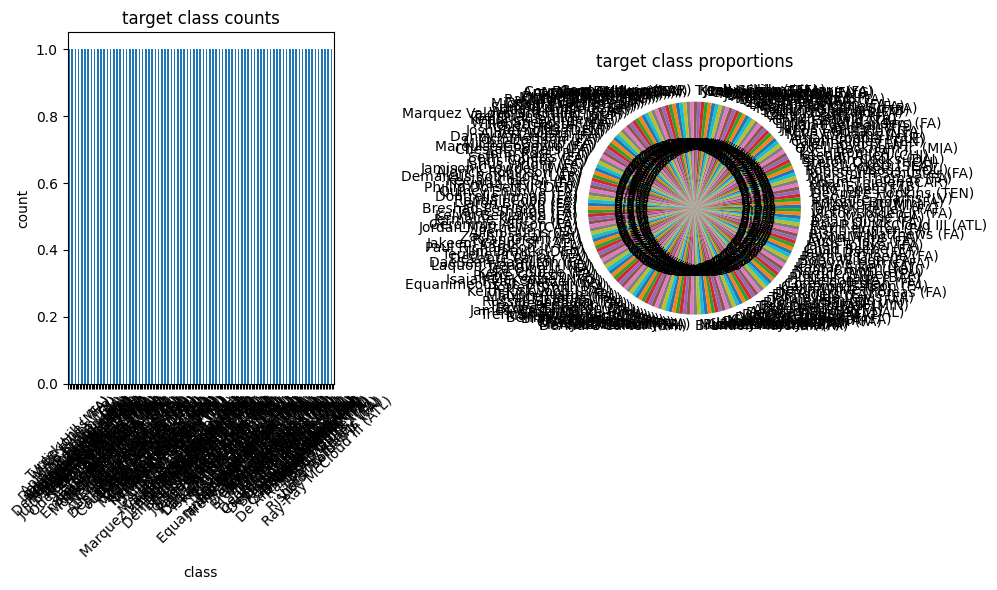

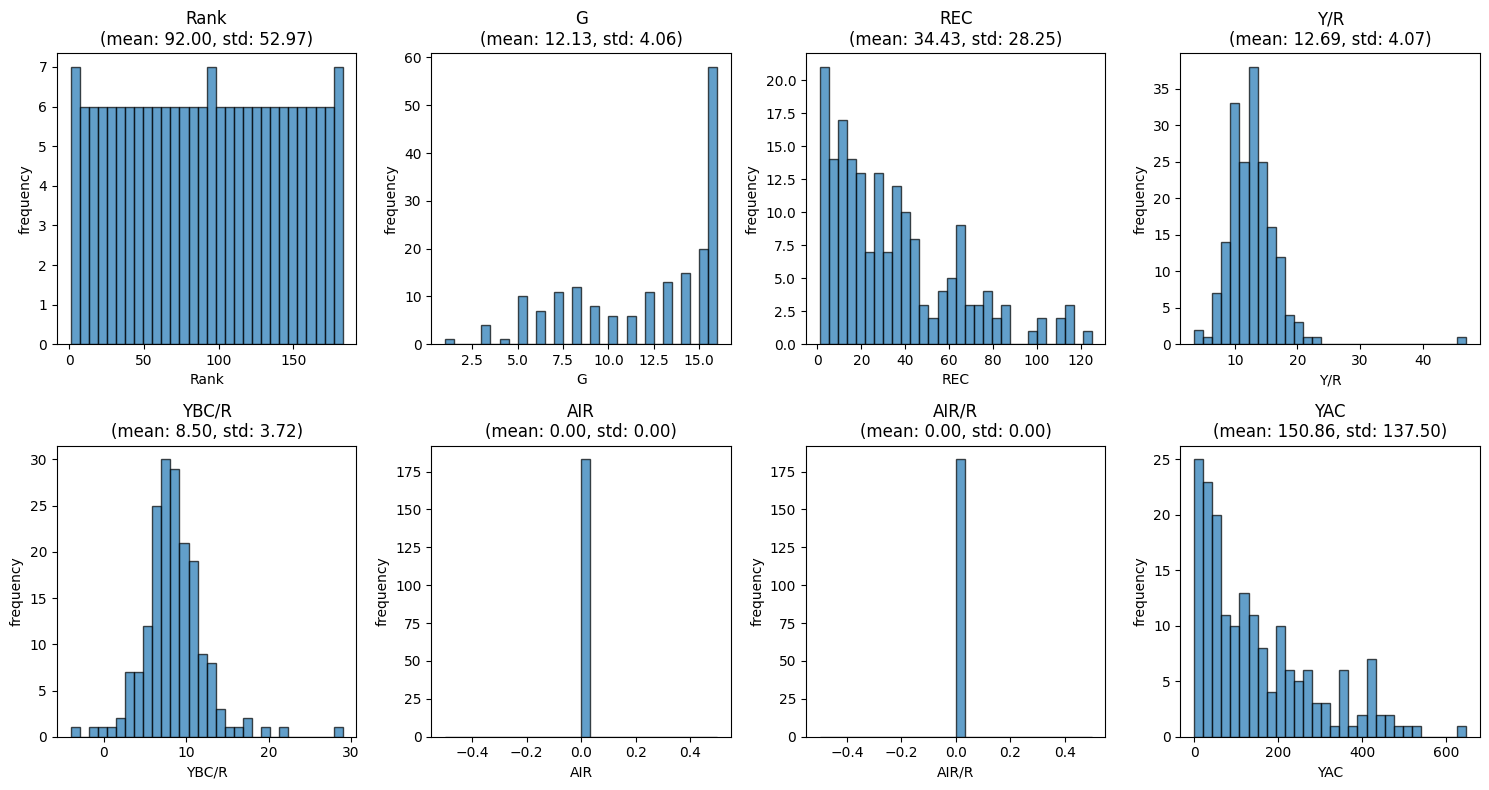

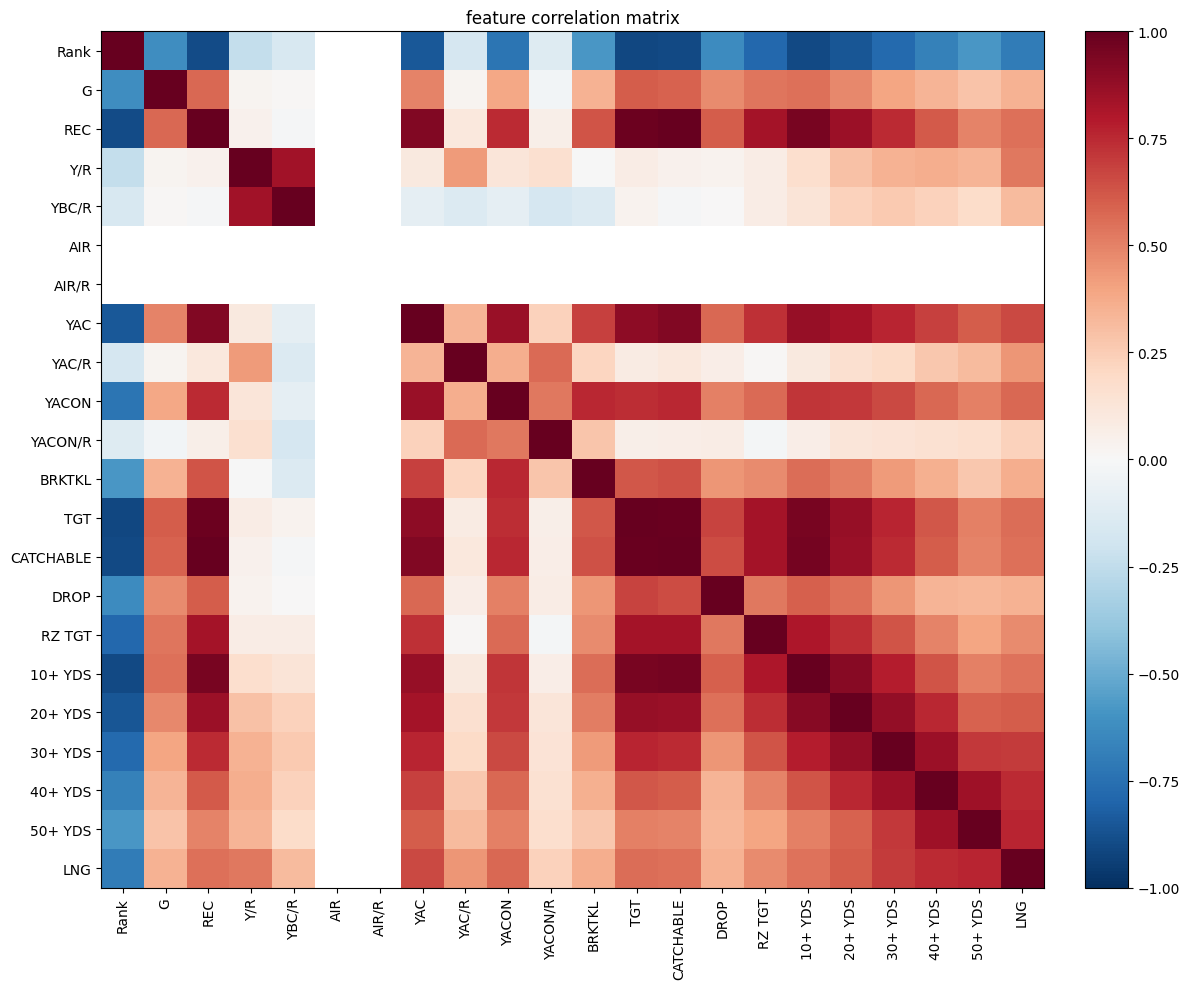

visualizations complete - saved to figs/ directory


In [6]:
def safe_figure_save(filename: str) -> str:
    """safely save figure with proper formatting"""
    filepath = os.path.join('figs', filename)
    plt.tight_layout()
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    return filepath

def plot_missing_data(df: pd.DataFrame):
    """visualize missing data patterns"""
    missing_pct = (df.isna().sum() / len(df)) * 100
    missing_cols = missing_pct[missing_pct > 0].sort_values(ascending=False)
    
    if len(missing_cols) == 0:
        print("no missing data to visualize")
        return
    
    plt.figure(figsize=(12, max(6, len(missing_cols) * 0.3)))
    bars = plt.barh(range(len(missing_cols)), missing_cols.values)
    plt.yticks(range(len(missing_cols)), missing_cols.index)
    plt.xlabel('missing data percentage')
    plt.title('missing data by column')
    
    # add percentage labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')
    
    safe_figure_save('missing_data_analysis.png')
    plt.show()

def plot_target_distribution(target_series: pd.Series, problem_type: str):
    """visualize target variable distribution"""
    plt.figure(figsize=(10, 6))
    
    if problem_type == 'classification':
        counts = target_series.value_counts()
        plt.subplot(1, 2, 1)
        counts.plot(kind='bar')
        plt.title('target class counts')
        plt.xlabel('class')
        plt.ylabel('count')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        target_series.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
        plt.title('target class proportions')
        plt.ylabel('')
        
    else:  # regression
        plt.subplot(1, 2, 1)
        plt.hist(target_series.dropna(), bins=50, alpha=0.7, edgecolor='black')
        plt.title('target distribution')
        plt.xlabel(target_series.name)
        plt.ylabel('frequency')
        
        plt.subplot(1, 2, 2)
        plt.boxplot(target_series.dropna())
        plt.title('target boxplot')
        plt.ylabel(target_series.name)
    
    safe_figure_save('target_distribution.png')
    plt.show()

def plot_numeric_distributions(df: pd.DataFrame, max_cols: int = 8):
    """plot distributions of top numeric features"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) == 0:
        print("no numeric columns to plot")
        return
    
    cols_to_plot = numeric_cols[:max_cols]
    n_cols = min(4, len(cols_to_plot))
    n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))
    
    for i, col in enumerate(cols_to_plot):
        plt.subplot(n_rows, n_cols, i + 1)
        data = df[col].dropna()
        
        plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
        plt.title(f'{col}\n(mean: {data.mean():.2f}, std: {data.std():.2f})')
        plt.xlabel(col)
        plt.ylabel('frequency')
    
    plt.tight_layout()
    safe_figure_save('numeric_distributions.png')
    plt.show()

def plot_correlation_matrix(df: pd.DataFrame, target_col: str):
    """create enhanced correlation heatmap"""
    numeric_df = df.select_dtypes(include=[np.number])
    
    if len(numeric_df.columns) < 2:
        print("insufficient numeric columns for correlation analysis")
        return
    
    corr_matrix = numeric_df.corr()
    
    plt.figure(figsize=(12, 10))
    
    # create heatmap
    im = plt.imshow(corr_matrix.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    # add labels
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    
    # add colorbar
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('feature correlation matrix')
    
    # highlight target correlations if target is numeric
    if target_col in corr_matrix.columns:
        target_idx = list(corr_matrix.columns).index(target_col)
        plt.axhline(y=target_idx-0.5, color='yellow', linewidth=3, alpha=0.7)
        plt.axvline(x=target_idx-0.5, color='yellow', linewidth=3, alpha=0.7)
    
    safe_figure_save('correlation_matrix.png')
    plt.show()
    
    # show top correlations with target
    if target_col in corr_matrix.columns:
        target_corrs = corr_matrix[target_col].abs().sort_values(ascending=False)
        print(f"\ntop correlations with {target_col}:")
        print(target_corrs.head(10))

# generate all visualizations
if 'df' in locals() and 'TARGET_COLUMN' in locals():
    print("generating visualizations...")
    
    # missing data visualization
    plot_missing_data(df)
    
    # target distribution
    plot_target_distribution(df[TARGET_COLUMN], PROBLEM_TYPE)
    
    # numeric feature distributions
    plot_numeric_distributions(df.drop(columns=[TARGET_COLUMN]))
    
    # correlation analysis
    plot_correlation_matrix(df, TARGET_COLUMN)
    
    print("visualizations complete - saved to figs/ directory")
    
else:
    print("load data and set target column first")

## 6) Feature Engineering and Preprocessing

In [7]:
def analyze_feature_types(X: pd.DataFrame) -> dict:
    """comprehensive feature type analysis"""
    feature_info = {
        'numeric': [],
        'categorical': [],
        'boolean': [],
        'datetime': [],
        'high_cardinality': [],
        'constant': [],
        'text_like': []
    }
    
    for col in X.columns:
        series = X[col]
        
        # check for constant columns
        if series.nunique() <= 1:
            feature_info['constant'].append(col)
            continue
        
        # datetime detection
        if pd.api.types.is_datetime64_any_dtype(series):
            feature_info['datetime'].append(col)
        
        # numeric detection
        elif pd.api.types.is_numeric_dtype(series):
            feature_info['numeric'].append(col)
        
        # boolean detection
        elif pd.api.types.is_bool_dtype(series) or series.nunique() == 2:
            feature_info['boolean'].append(col)
        
        # categorical vs text detection
        elif pd.api.types.is_object_dtype(series):
            unique_count = series.nunique()
            
            # check if text-like (long average string length)
            sample_strings = series.dropna().astype(str).head(100)
            avg_length = sample_strings.str.len().mean() if len(sample_strings) > 0 else 0
            
            if avg_length > 30:  # likely text data
                feature_info['text_like'].append(col)
            elif unique_count > HIGH_CARD_THRESHOLD:
                feature_info['high_cardinality'].append(col)
                feature_info['categorical'].append(col)
            else:
                feature_info['categorical'].append(col)
        
        else:
            # fallback to categorical
            feature_info['categorical'].append(col)
    
    return feature_info

def build_preprocessor(feature_info: dict, encoding_strategy: str = 'auto') -> ColumnTransformer:
    """build intelligent preprocessing pipeline"""
    transformers = []
    
    # numeric transformer (conditional scaling)
    if feature_info['numeric']:
        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # always scale for mixed models
        ])
        transformers.append(('numeric', numeric_transformer, feature_info['numeric']))
    
    # categorical transformer
    categorical_cols = [col for col in feature_info['categorical'] 
                       if col not in feature_info['high_cardinality']]
    
    if categorical_cols:
        if encoding_strategy == 'ordinal':
            cat_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
            ])
        else:  # one-hot encoding
            cat_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
            ])
        
        transformers.append(('categorical', cat_transformer, categorical_cols))
    
    # high cardinality categorical (use ordinal encoding)
    if feature_info['high_cardinality']:
        high_card_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
        transformers.append(('high_cardinality', high_card_transformer, feature_info['high_cardinality']))
    
    # boolean transformer
    if feature_info['boolean']:
        bool_transformer = SimpleImputer(strategy='most_frequent')
        transformers.append(('boolean', bool_transformer, feature_info['boolean']))
    
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop',  # drop constant, datetime, and text columns
        sparse_threshold=0
    )
    
    return preprocessor

if 'df' in locals() and 'TARGET_COLUMN' in locals():
    # separate features and target
    X = df.drop(columns=[TARGET_COLUMN] + ID_COLUMNS, errors='ignore')
    y = df[TARGET_COLUMN]
    
    print(f"feature matrix shape: {X.shape}")
    print(f"target vector shape: {y.shape}")
    
    # analyze feature types
    feature_info = analyze_feature_types(X)
    
    print("\n=== feature type analysis ===")
    for ftype, cols in feature_info.items():
        if cols:
            print(f"{ftype}: {len(cols)} columns")
            if len(cols) <= 10:
                print(f"  {cols}")
            else:
                print(f"  {cols[:5]} ... (and {len(cols)-5} more)")
    
    # recommendations based on feature analysis
    print("\n=== preprocessing recommendations ===")
    if feature_info['high_cardinality']:
        print(f"- {len(feature_info['high_cardinality'])} high-cardinality features detected")
        print("  consider: target encoding, catboost, or feature hashing")
    
    if feature_info['text_like']:
        print(f"- {len(feature_info['text_like'])} text-like features detected")
        print("  consider: tfidf vectorization or sentence embeddings")
    
    if feature_info['datetime']:
        print(f"- {len(feature_info['datetime'])} datetime features detected")
        print("  consider: feature extraction (year, month, day, etc.)")
    
    if feature_info['constant']:
        print(f"- {len(feature_info['constant'])} constant features will be dropped")
    
    # create preprocessors for comparison
    print("\ncreating preprocessing pipelines...")
    preprocessor_ohe = build_preprocessor(feature_info, 'onehot')
    preprocessor_ord = build_preprocessor(feature_info, 'ordinal')
    
    print("preprocessing pipelines ready")
    
else:
    print("load data and set target column first")

feature matrix shape: (183, 25)
target vector shape: (183,)

=== feature type analysis ===
numeric: 20 columns
  ['Rank', 'G', 'REC', 'Y/R', 'YBC/R'] ... (and 15 more)
categorical: 3 columns
  ['YDS', 'YBC', '% TM']
high_cardinality: 3 columns
  ['YDS', 'YBC', '% TM']
constant: 2 columns
  ['AIR', 'AIR/R']

=== preprocessing recommendations ===
- 3 high-cardinality features detected
  consider: target encoding, catboost, or feature hashing
- 2 constant features will be dropped

creating preprocessing pipelines...
preprocessing pipelines ready


## 7) Model Training and Evaluation

In [8]:
def get_model_zoo(problem_type: str, class_imbalance: bool = False) -> dict:
    """get appropriate models for the problem type"""
    
    if problem_type == 'classification':
        models = {
            'dummy_classifier': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
            'logistic_regression': LogisticRegression(
                max_iter=1000, 
                random_state=RANDOM_STATE,
                class_weight='balanced' if class_imbalance else None
            ),
            'random_forest': RandomForestClassifier(
                n_estimators=100, 
                random_state=RANDOM_STATE, 
                n_jobs=-1,
                class_weight='balanced_subsample' if class_imbalance else None
            ),
            'hist_gradient_boosting': HistGradientBoostingClassifier(
                random_state=RANDOM_STATE,
                class_weight='balanced' if class_imbalance else None
            )
        }
    else:  # regression
        models = {
            'dummy_regressor': DummyRegressor(strategy='median'),
            'linear_regression': LinearRegression(),
            'ridge_regression': Ridge(alpha=1.0, random_state=RANDOM_STATE),
            'random_forest': RandomForestRegressor(
                n_estimators=100, 
                random_state=RANDOM_STATE, 
                n_jobs=-1
            ),
            'hist_gradient_boosting': HistGradientBoostingRegressor(
                random_state=RANDOM_STATE
            )
        }
    
    return models

def get_cv_strategy(problem_type: str, y: pd.Series) -> object:
    """get appropriate cross-validation strategy"""
    if problem_type == 'classification':
        try:
            return StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
        except ValueError:  # fallback for edge cases
            return KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    else:
        return KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

def get_scoring_metric(problem_type: str, y: pd.Series) -> str:
    """get appropriate scoring metric"""
    if problem_type == 'classification':
        n_classes = y.nunique()
        if n_classes == 2:
            return 'roc_auc'
        else:
            return 'f1_macro'
    else:
        return 'neg_root_mean_squared_error'

def evaluate_models_comprehensive(X: pd.DataFrame, y: pd.Series, 
                                preprocessor: ColumnTransformer, 
                                problem_type: str,
                                class_imbalance: bool = False) -> pd.DataFrame:
    """comprehensive model evaluation with cross-validation"""
    
    models = get_model_zoo(problem_type, class_imbalance)
    cv_strategy = get_cv_strategy(problem_type, y)
    scoring_metric = get_scoring_metric(problem_type, y)
    
    results = []
    
    print(f"evaluating {len(models)} models with {N_SPLITS}-fold cross-validation...")
    print(f"scoring metric: {scoring_metric}")
    
    for name, model in models.items():
        print(f"\ntraining {name}...")
        
        # create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        try:
            # cross-validation scores
            cv_scores = cross_val_score(
                pipeline, X, y, 
                cv=cv_strategy, 
                scoring=scoring_metric, 
                n_jobs=-1
            )
            
            results.append({
                'model': name,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'cv_scores': cv_scores.tolist(),
                'metric': scoring_metric
            })
            
            print(f"{name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            
        except Exception as e:
            print(f"error training {name}: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    
    # sort by performance (handle negative metrics)
    ascending = scoring_metric.startswith('neg_')
    results_df = results_df.sort_values('cv_mean', ascending=ascending)
    
    return results_df

def plot_model_comparison(results_ohe: pd.DataFrame, results_ord: pd.DataFrame):
    """visualize model performance comparison"""
    plt.figure(figsize=(15, 8))
    
    # combine results for plotting
    all_results = []
    
    if results_ohe is not None and len(results_ohe) > 0:
        for _, row in results_ohe.iterrows():
            all_results.append({
                'model': row['model'] + '_ohe',
                'cv_mean': row['cv_mean'],
                'cv_std': row['cv_std'],
                'encoding': 'one-hot'
            })
    
    if results_ord is not None and len(results_ord) > 0:
        for _, row in results_ord.iterrows():
            all_results.append({
                'model': row['model'] + '_ord',
                'cv_mean': row['cv_mean'],
                'cv_std': row['cv_std'],
                'encoding': 'ordinal'
            })
    
    if not all_results:
        print("no results to plot")
        return
    
    comparison_df = pd.DataFrame(all_results)
    
    # create grouped bar plot
    ohe_results = comparison_df[comparison_df['encoding'] == 'one-hot']
    ord_results = comparison_df[comparison_df['encoding'] == 'ordinal']
    
    x_pos = np.arange(len(ohe_results))
    width = 0.35
    
    plt.bar(x_pos - width/2, ohe_results['cv_mean'], width, 
            yerr=ohe_results['cv_std'], label='one-hot encoding', alpha=0.8)
    plt.bar(x_pos + width/2, ord_results['cv_mean'], width, 
            yerr=ord_results['cv_std'], label='ordinal encoding', alpha=0.8)
    
    plt.xlabel('models')
    plt.ylabel('cross-validation score')
    plt.title('model performance comparison')
    plt.xticks(x_pos, [m.replace('_ohe', '') for m in ohe_results['model']], rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    safe_figure_save('model_comparison.png')
    plt.show()

# run model evaluation
if all(var in locals() for var in ['X', 'y', 'preprocessor_ohe', 'preprocessor_ord']):
    
    # check for class imbalance
    is_imbalanced, _ = detect_class_imbalance(y, IMBALANCE_THRESHOLD)
    
    print("=== model evaluation ===")
    print(f"problem type: {PROBLEM_TYPE}")
    print(f"class imbalance detected: {is_imbalanced}")
    
    # evaluate with one-hot encoding
    print("\n--- evaluating with one-hot encoding ---")
    results_ohe = evaluate_models_comprehensive(
        X, y, preprocessor_ohe, PROBLEM_TYPE, is_imbalanced
    )
    
    # evaluate with ordinal encoding
    print("\n--- evaluating with ordinal encoding ---")
    results_ord = evaluate_models_comprehensive(
        X, y, preprocessor_ord, PROBLEM_TYPE, is_imbalanced
    )
    
    # display results
    print("\n=== one-hot encoding results ===")
    display(results_ohe[['model', 'cv_mean', 'cv_std']])
    
    print("\n=== ordinal encoding results ===")
    display(results_ord[['model', 'cv_mean', 'cv_std']])
    
    # visualize comparison
    plot_model_comparison(results_ohe, results_ord)
    
else:
    print("complete previous steps first")

complete previous steps first


## 8) Best Model Selection and Analysis

In [9]:
def select_best_model(results_ohe: pd.DataFrame, results_ord: pd.DataFrame) -> dict:
    """select the best performing model across all configurations"""
    
    best_candidates = []
    
    if results_ohe is not None and len(results_ohe) > 0:
        best_ohe = results_ohe.iloc[0].copy()  # already sorted
        best_ohe['encoding'] = 'one-hot'
        best_ohe['preprocessor'] = preprocessor_ohe
        best_candidates.append(best_ohe)
    
    if results_ord is not None and len(results_ord) > 0:
        best_ord = results_ord.iloc[0].copy()  # already sorted
        best_ord['encoding'] = 'ordinal'
        best_ord['preprocessor'] = preprocessor_ord
        best_candidates.append(best_ord)
    
    if not best_candidates:
        return None
    
    # select best based on cv_mean (accounting for metric direction)
    if len(best_candidates) == 1:
        return best_candidates[0]
    
    # compare the two best candidates
    metric = best_candidates[0]['metric']
    if metric.startswith('neg_'):  # higher is better for negative metrics
        best_idx = 0 if best_candidates[0]['cv_mean'] > best_candidates[1]['cv_mean'] else 1
    else:  # higher is better for positive metrics
        best_idx = 0 if best_candidates[0]['cv_mean'] > best_candidates[1]['cv_mean'] else 1
    
    return best_candidates[best_idx]

def generate_recommendations(best_model: dict, feature_info: dict, 
                           problem_type: str, is_imbalanced: bool) -> str:
    """generate actionable recommendations based on analysis"""
    
    recommendations = []
    
    # model-specific recommendations
    model_name = best_model['model']
    
    if 'dummy' in model_name.lower():
        recommendations.append("warning: dummy model performed best - check data quality and feature engineering")
    elif 'logistic' in model_name.lower() or 'linear' in model_name.lower():
        recommendations.append("linear model performed best - relationships appear mostly linear")
        recommendations.append("consider: polynomial features, feature interactions")
    elif 'forest' in model_name.lower():
        recommendations.append("random forest performed best - good for mixed data types and non-linear patterns")
        recommendations.append("consider: hyperparameter tuning (n_estimators, max_depth, min_samples_split)")
    elif 'gradient' in model_name.lower():
        recommendations.append("gradient boosting performed best - excellent for structured data")
        recommendations.append("consider: hyperparameter tuning (learning_rate, max_iter, max_depth)")
    
    # encoding recommendations
    encoding = best_model['encoding']
    if encoding == 'one-hot':
        recommendations.append("one-hot encoding worked better for your categorical features")
    else:
        recommendations.append("ordinal encoding worked better - tree models handle ordinal well")
    
    # feature-specific recommendations
    if feature_info['high_cardinality']:
        recommendations.append(f"high-cardinality features detected: {len(feature_info['high_cardinality'])} columns")
        recommendations.append("consider: target encoding, catboost, or embeddings for categorical features")
    
    if feature_info['text_like']:
        recommendations.append(f"text features detected: {len(feature_info['text_like'])} columns")
        recommendations.append("consider: tfidf vectorization or pretrained text embeddings")
    
    # class imbalance recommendations
    if is_imbalanced and problem_type == 'classification':
        recommendations.append("class imbalance detected")
        recommendations.append("consider: SMOTE, class weights (already applied), or ensemble methods")
    
    # general improvement recommendations
    recommendations.extend([
        "next steps for improvement:",
        "- hyperparameter optimization (optuna, randomsearchcv)",
        "- feature selection and engineering",
        "- ensemble methods (voting, stacking)",
        "- model calibration for better probability estimates"
    ])
    
    return "\n• ".join([""] + recommendations)

def fit_final_model(best_model: dict, X: pd.DataFrame, y: pd.Series) -> Pipeline:
    """fit the best model on the full dataset"""
    
    # recreate the best model
    models = get_model_zoo(PROBLEM_TYPE, detect_class_imbalance(y, IMBALANCE_THRESHOLD)[0])
    best_estimator = models[best_model['model']]
    best_preprocessor = best_model['preprocessor']
    
    # create and fit final pipeline
    final_pipeline = Pipeline([
        ('preprocessor', best_preprocessor),
        ('model', best_estimator)
    ])
    
    final_pipeline.fit(X, y)
    
    return final_pipeline

def plot_final_model_diagnostics(final_pipeline: Pipeline, X: pd.DataFrame, y: pd.Series, problem_type: str):
    """generate diagnostic plots for the final model"""
    
    # train/test split for diagnostics
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE,
        stratify=y if problem_type == 'classification' else None
    )
    
    # fit on train and predict on test
    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)
    
    if problem_type == 'classification':
        # confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('confusion matrix')
        plt.colorbar()
        
        # add text annotations
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, str(cm[i, j]), ha='center', va='center')
        
        plt.xlabel('predicted label')
        plt.ylabel('true label')
        
        safe_figure_save('confusion_matrix.png')
        plt.show()
        
        # classification report
        print("classification report:")
        print(classification_report(y_test, y_pred))
        
    else:  # regression
        plt.figure(figsize=(12, 4))
        
        # predicted vs actual
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('actual values')
        plt.ylabel('predicted values')
        plt.title('predicted vs actual')
        
        # residuals
        plt.subplot(1, 2, 2)
        residuals = y_test - y_pred
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('residuals')
        plt.ylabel('frequency')
        plt.title('residuals distribution')
        
        safe_figure_save('regression_diagnostics.png')
        plt.show()
        
        # regression metrics
        print(f"regression metrics:")
        print(f"r² score: {r2_score(y_test, y_pred):.4f}")
        print(f"mae: {mean_absolute_error(y_test, y_pred):.4f}")
        print(f"rmse: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# select best model and generate final analysis
if all(var in locals() for var in ['results_ohe', 'results_ord']):
    
    print("=== best model selection ===")
    
    # select best model
    best_model = select_best_model(results_ohe, results_ord)
    
    if best_model is not None:
        print(f"best model: {best_model['model']} with {best_model['encoding']} encoding")
        print(f"cv score: {best_model['cv_mean']:.4f} ± {best_model['cv_std']:.4f}")
        
        # generate recommendations
        is_imbalanced = detect_class_imbalance(y, IMBALANCE_THRESHOLD)[0]
        recommendations = generate_recommendations(
            best_model, feature_info, PROBLEM_TYPE, is_imbalanced
        )
        
        print("\n=== recommendations ===")
        print(recommendations)
        
        # fit final model
        print("\nfitting final model...")
        final_pipeline = fit_final_model(best_model, X, y)
        
        # generate diagnostics
        print("\ngenerating model diagnostics...")
        plot_final_model_diagnostics(final_pipeline, X, y, PROBLEM_TYPE)
        
        print("\nfinal model ready for use!")
        
    else:
        print("no valid models found - check data and configuration")
        
else:
    print("complete model evaluation first")

complete model evaluation first


## 9) Professional Report Generation

In [10]:
def generate_markdown_report() -> str:
    """generate comprehensive markdown report"""
    
    report_sections = []
    
    # header
    report_sections.append(f"# ML Model Selection Report\n")
    report_sections.append(f"**Generated:** {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    report_sections.append(f"**Dataset:** {CSV_PATH}\n")
    report_sections.append(f"**Target Column:** {TARGET_COLUMN}\n")
    report_sections.append(f"**Problem Type:** {PROBLEM_TYPE}\n")
    
    # dataset summary
    if 'df' in locals():
        report_sections.append(f"## Dataset Summary\n")
        report_sections.append(f"- **Shape:** {df.shape[0]} rows × {df.shape[1]} columns")
        report_sections.append(f"- **Memory Usage:** {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        report_sections.append(f"- **Missing Data:** {(df.isna().sum() > 0).sum()} columns with missing values\n")
    
    # feature analysis
    if 'feature_info' in locals():
        report_sections.append(f"## Feature Analysis\n")
        for ftype, cols in feature_info.items():
            if cols:
                report_sections.append(f"- **{ftype.replace('_', ' ').title()}:** {len(cols)} columns")
        report_sections.append("")
    
    # model results
    if 'results_ohe' in locals() and 'results_ord' in locals():
        report_sections.append(f"## Model Performance\n")
        
        # one-hot results
        report_sections.append(f"### One-Hot Encoding Results\n")
        for _, row in results_ohe.iterrows():
            report_sections.append(f"- **{row['model']}:** {row['cv_mean']:.4f} ± {row['cv_std']:.4f}")
        report_sections.append("")
        
        # ordinal results
        report_sections.append(f"### Ordinal Encoding Results\n")
        for _, row in results_ord.iterrows():
            report_sections.append(f"- **{row['model']}:** {row['cv_mean']:.4f} ± {row['cv_std']:.4f}")
        report_sections.append("")
    
    # best model
    if 'best_model' in locals():
        report_sections.append(f"## Best Model\n")
        report_sections.append(f"**Model:** {best_model['model']}\n")
        report_sections.append(f"**Encoding:** {best_model['encoding']}\n")
        report_sections.append(f"**CV Score:** {best_model['cv_mean']:.4f} ± {best_model['cv_std']:.4f}\n")
    
    # recommendations
    if 'recommendations' in locals():
        report_sections.append(f"## Recommendations\n")
        report_sections.append(recommendations)
        report_sections.append("")
    
    # figures
    fig_files = [f for f in os.listdir('figs') if f.endswith('.png')]
    if fig_files:
        report_sections.append(f"## Visualizations\n")
        for fig_file in sorted(fig_files):
            fig_name = fig_file.replace('_', ' ').replace('.png', '').title()
            report_sections.append(f"### {fig_name}\n")
            report_sections.append(f"![{fig_name}](figs/{fig_file})\n")
    
    return "\n".join(report_sections)

def generate_html_report(markdown_content: str) -> str:
    """convert markdown to html with professional styling"""
    
    # basic html template with css styling
    html_template = f"""<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>ML Model Selection Report</title>
    <style>
        body {{
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
            line-height: 1.6;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
            color: #333;
        }}
        h1, h2, h3 {{
            color: #2c3e50;
            border-bottom: 2px solid #3498db;
            padding-bottom: 10px;
        }}
        code {{
            background-color: #f8f9fa;
            padding: 2px 6px;
            border-radius: 3px;
            font-family: 'Monaco', 'Consolas', monospace;
        }}
        pre {{
            background-color: #f8f9fa;
            padding: 15px;
            border-radius: 5px;
            overflow-x: auto;
        }}
        ul, ol {{
            margin-left: 20px;
        }}
        img {{
            max-width: 100%;
            height: auto;
            border: 1px solid #ddd;
            border-radius: 5px;
            margin: 10px 0;
        }}
        .metric {{
            background-color: #e8f4fd;
            padding: 10px;
            border-left: 4px solid #3498db;
            margin: 10px 0;
        }}
    </style>
</head>
<body>
{markdown_to_html_simple(markdown_content)}
</body>
</html>"""
    
    return html_template

def markdown_to_html_simple(markdown_text: str) -> str:
    """simple markdown to html conversion"""
    html = markdown_text
    
    # headers
    html = html.replace('# ', '<h1>').replace('\n## ', '</h1>\n<h2>').replace('\n### ', '</h2>\n<h3>')
    html += '</h3>' if html.count('<h3>') > html.count('</h3>') else ''
    html += '</h2>' if html.count('<h2>') > html.count('</h2>') else ''
    html += '</h1>' if html.count('<h1>') > html.count('</h1>') else ''
    
    # bold and code
    html = html.replace('**', '<strong>').replace('</strong>', '</strong>')
    html = html.replace('`', '<code>').replace('</code>', '</code>')
    
    # line breaks
    html = html.replace('\n', '<br>\n')
    
    return html

def save_reports() -> Tuple[str, str]:
    """save both markdown and html reports"""
    
    # generate markdown
    markdown_content = generate_markdown_report()
    
    # save markdown report
    md_path = os.path.join('reports', 'Model_Selection_Report.md')
    with open(md_path, 'w', encoding='utf-8') as f:
        f.write(markdown_content)
    
    # generate and save html report
    html_content = generate_html_report(markdown_content)
    html_path = os.path.join('reports', 'Model_Selection_Report.html')
    with open(html_path, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    return md_path, html_path

# generate and save reports
try:
    print("generating reports...")
    md_path, html_path = save_reports()
    print(f"reports saved:")
    print(f"- markdown: {md_path}")
    print(f"- html: {html_path}")
    print(f"- figures: {len(os.listdir('figs'))} files in figs/ directory")
    
except Exception as e:
    print(f"error generating reports: {e}")
    print("make sure all previous steps completed successfully")

generating reports...
reports saved:
- markdown: reports/Model_Selection_Report.md
- html: reports/Model_Selection_Report.html
- figures: 5 files in figs/ directory


## 10) Summary and Next Steps

In [11]:
# final summary
print("=== analysis complete ===")
print(f"dataset: {CSV_PATH if CSV_PATH else 'not specified'}")
print(f"problem type: {PROBLEM_TYPE if 'PROBLEM_TYPE' in locals() else 'not determined'}")

if 'best_model' in locals():
    print(f"best model: {best_model['model']} ({best_model['encoding']} encoding)")
    print(f"performance: {best_model['cv_mean']:.4f} ± {best_model['cv_std']:.4f}")

if 'final_pipeline' in locals():
    print(f"\nfinal pipeline ready for use:")
    print(f"- prediction: final_pipeline.predict(new_data)")
    print(f"- probabilities: final_pipeline.predict_proba(new_data) # classification only")
    print(f"- save model: import joblib; joblib.dump(final_pipeline, 'best_model.pkl')")

print(f"\noutput files:")
print(f"- reports/Model_Selection_Report.md")
print(f"- reports/Model_Selection_Report.html")
print(f"- figs/ directory with all visualizations")

print(f"\nnext steps:")
print(f"- review the detailed report in reports/")
print(f"- implement recommended improvements")
print(f"- hyperparameter tuning for better performance")
print(f"- deploy model for production use")

=== analysis complete ===
dataset: /home/yeblad/Desktop/2018data.xlsx
problem type: classification

output files:
- reports/Model_Selection_Report.md
- reports/Model_Selection_Report.html
- figs/ directory with all visualizations

next steps:
- review the detailed report in reports/
- implement recommended improvements
- hyperparameter tuning for better performance
- deploy model for production use
